In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import argparse
import os
import shutil
from datetime import datetime

from experiments.datasets import Datasets

import tensorflow as tf
import gpflow
# from gpflow.saver import Saver
# from gpflow import settings
# import gpflow.training.monitor as mon

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.utils import shuffle

# from nssm_gp.initializers import init_gsm, init_spectral, init_neural
from nssm_gp.initializers import init_spectral
from nssm_gp.spectral_kernels import SMKernel


float_type = gpflow.default_float()

In [3]:
# Model / inference hyperparameters
NUM_INDUCING_POINTS = 100
LEARNING_RATE = 1e-4
BATCH_SIZE = 512
Q = 3
MAX_FREQ = 20.0
MAX_LEN = 10.0
EPOCHS = 500
LATENT_ELL = 1.0


In [4]:
def simple_model(x, y, likelihood, M=NUM_INDUCING_POINTS, bs=BATCH_SIZE, ARD=True):
    # Gaussian kernel
    ell = np.std(x)
    var = np.std(y)
    print(var)
    kern_rbf = gpflow.kernels.RBF(x.shape[1], variance=var, lengthscales=ell, ARD=ARD)
    # Randomly select inducing point locations among given inputs
    idx = np.random.randint(len(x), size=M)
    Z = x[idx, :].copy()
    # Create SVGP with Gaussian likelihood
    m_rbf = gpflow.models.SVGP(x, y, kern_rbf, likelihood,
                               Z, minibatch_size=bs)
    return m_rbf


In [5]:
model_functions = {
    'sm': lambda x, y, likelihood, q=Q, ARD=False, bs=BATCH_SIZE, M=NUM_INDUCING_POINTS: init_spectral(x, y, kern=SMKernel, n_inits=5,
                                     M=M, Q=q, minibatch_size=bs, noise_var=0.1, ARD=ARD, likelihood=likelihood),
    'rbf': simple_model,
}

In [6]:
print('Tensorflow: %s' % tf.__version__)
print('GPflow: %s' % gpflow.__version__)

Tensorflow: 2.6.0
GPflow: 2.2.1


In [7]:
datasets = Datasets('./data/')

In [8]:
datasets

In [9]:
datasets.all_datasets.keys()

dict_keys(['boston', 'concrete', 'energy', 'kin8nm', 'mcycle', 'naval', 'power', 'protein', 'wine_red', 'wine_white', 'skin', 'mocap', 'mocap2', 'sunspots', 'radiance'])

In [10]:
# kernel = 'rbf'
kernel = 'sm'
data = 'sunspots'
q = Q
ard = False
lr = LEARNING_RATE
bs = BATCH_SIZE
m = NUM_INDUCING_POINTS

In [11]:
print('Loading data...')
dataset = datasets.all_datasets[data]
data = dataset.get_data()

Loading data...


In [12]:
data.keys()

dict_keys(['X', 'Xs', 'Y', 'Ys', 'X_mean', 'X_std', 'Y_mean', 'Y_std'])

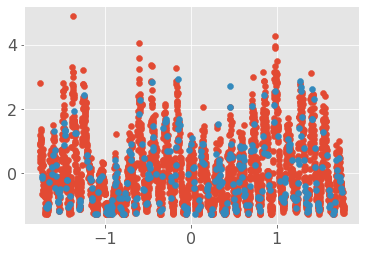

In [13]:
plt.figure()
plt.scatter(data["X"], data["Y"])
plt.scatter(data["Xs"], data["Ys"])

In [14]:
# Reset seed to get different shuffles (and model initialization below)
np.random.seed(None)
data['X'], data['Y'] = shuffle(data['X'], data['Y'])

In [15]:
likelihood = gpflow.likelihoods.Gaussian(0.1**2)

2021-09-27 11:57:48.030338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,,True,(),float64,0.01


In [17]:
np.std(data['Y'])

1.0546947653311463

In [18]:
data['X'].shape

(2911, 1)

In [19]:
if kernel == 'rbf':
    model = model_functions[kernel](data['X'], data['Y'], ARD=ard, likelihood=likelihood,
                                         bs=int(bs), M=int(m))
else:
    model = model_functions[kernel](data['X'], data['Y'], q=int(q), ARD=ard, likelihood=likelihood,
                                         bs=int(bs), M=int(m))

Initializing a spectral kernel...


AttributeError: module 'gpflow' has no attribute 'priors'